In [1]:
import torch
import torchvision

import torch.nn as nn

import torchvision.transforms.v2 as transforms

from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchinfo import summary

import matplotlib.pyplot as plt

In [2]:
if torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
    
else:
    print ("Cuda device not found.")

tensor([1.], device='cuda:0')


## First define base model C from table 1 and train on Cifar10

In [31]:
class base_c(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.dropout1 = nn.Dropout2d(p=0.2)
        
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=96,
            kernel_size=(3,3),
            stride=1, padding=2, bias=False,
        )
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(
            in_channels=96, out_channels=96,
            kernel_size=(3,3),
            stride=1, padding=2, bias=False,
        )
        self.relu2 = nn.ReLU()
        
        self.mp1 = nn.MaxPool2d(
            stride=2, kernel_size=(3,3), padding=0,
        )
        self.dropout2 = nn.Dropout2d(p=0.5)
        
        self.conv3 = nn.Conv2d(
            in_channels=96, out_channels=192,
            kernel_size=(3,3),
            stride=1, padding=1, bias=False,
        )
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(
            in_channels=192, out_channels=192,
            kernel_size=(3,3),
            stride=1, padding=1, bias=False,
        )
        self.relu4 = nn.ReLU()
        
        self.mp2 = nn.MaxPool2d(
            stride=2, kernel_size=(3,3), padding=0,
        )
        self.dropout3 = nn.Dropout2d(p=0.5)
        
        self.conv5 = nn.Conv2d(
            in_channels=192, out_channels=192,
            kernel_size=(3,3),
            stride=1, padding=0, bias=False,
        )
        self.relu5 = nn.ReLU()
        
        self.conv6 = nn.Conv2d(
            in_channels=192, out_channels=192,
            kernel_size=(1,1),
            stride=1, padding=0, bias=False,
        )
        self.relu6 = nn.ReLU()
        
        self.conv7 = nn.Conv2d(
            in_channels=192, out_channels=10,
            kernel_size=(1,1),
            stride=1, padding=0, bias=False,
        )
        self.relu7 = nn.ReLU()
        
        self.avg_pool = nn.AvgPool2d(
            #kernel_size=(6,6)
            kernel_size=(54,54)  # For ImageNette naive approach, may need to add more layers instead
        )
        
        
    def forward(self, x):
        #print(x.shape)
        x = self.dropout1(x)
        #print(f'Shape after dropout1: {x.shape}')
        x = self.conv1(x)
        x = self.relu1(x)
        #print(f'Shape after conv1: {x.shape}')
        x = self.conv2(x)
        x = self.relu2(x)
        #print(f'Shape after conv2: {x.shape}')
        x = self.mp1(x)
        #print(f'Shape after mp1: {x.shape}')
        x = self.dropout2(x)
        #print(f'Shape after dropout2: {x.shape}')
        x = self.conv3(x)
        x = self.relu3(x)
        #print(f'Shape after conv3: {x.shape}')
        x = self.conv4(x)
        x = self.relu4(x)
        #print(f'Shape after conv4: {x.shape}')
        x = self.mp2(x)
        #print(f'Shape after mp2: {x.shape}')
        x = self.dropout3(x)
        #print(f'Shape after dropout3: {x.shape}')
        x = self.conv5(x)
        x = self.relu5(x)
        #print(f'Shape after conv5: {x.shape}')
        x = self.conv6(x)
        x = self.relu6(x)
        #print(f'Shape after conv6: {x.shape}')
        x = self.conv7(x)
        x = self.relu7(x)
        #print(f'Shape after conv7: {x.shape}')
        x = self.avg_pool(x)
        #print(f'Shape after global pool layer: {x.shape}')
        x = torch.flatten(x, start_dim=1)
        #print(f'out shape: {x.shape}')
        
        return x

def glorot_init(net):
    if isinstance(net, nn.Conv2d):
        nn.init.xavier_normal_(net.weight)
        if net.bias is not None:
            nn.init.constant_(net.bias, 0)      

base_model_c = base_c()
base_model_c.apply(glorot_init)
base_model_c = base_model_c.to(device)
summary(base_model_c, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
base_c                                   [1, 10]                   --
├─Dropout2d: 1-1                         [1, 3, 224, 224]          --
├─Conv2d: 1-2                            [1, 96, 226, 226]         2,592
├─ReLU: 1-3                              [1, 96, 226, 226]         --
├─Conv2d: 1-4                            [1, 96, 228, 228]         82,944
├─ReLU: 1-5                              [1, 96, 228, 228]         --
├─MaxPool2d: 1-6                         [1, 96, 113, 113]         --
├─Dropout2d: 1-7                         [1, 96, 113, 113]         --
├─Conv2d: 1-8                            [1, 192, 113, 113]        165,888
├─ReLU: 1-9                              [1, 192, 113, 113]        --
├─Conv2d: 1-10                           [1, 192, 113, 113]        331,776
├─ReLU: 1-11                             [1, 192, 113, 113]        --
├─MaxPool2d: 1-12                        [1, 192, 56, 56]          -

### Loading Cifar10

In [ ]:
# Implement GCN and ZCA

In [4]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

'''transform = transforms.Compose([
    #transforms.Resize(224), # Not needed for All CNN paper
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.48227 ,0.4465], std=[0.2470, 0.2435, 0.2616]), 
])'''

transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #GlobalContrastNormalization(mean=0.0, std=1.0),
    transforms.Normalize(mean=[0.4914, 0.48227 ,0.4465], std=[0.2470, 0.2435, 0.2616]),
    #ZCAWhitening(),  # Uncomment after ensuring its feasibility on your dataset size and memory constraints 
])

# Load datasets
train_dataset = CIFAR10(root='./CIFAR', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./CIFAR', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4) # 256 batch size for imagenet
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

/home/yusuf/anaconda3/envs/gpu_use/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


## ImageNette Loading

In [25]:
# Define transformations
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

TRAIN_DATA_DIR = './data/imagenette2-160/train'
TEST_DATA_DIR = './data/imagenette2-160/val'

# Load ImageNette dataset
trainset = torchvision.datasets.ImageFolder(
        TRAIN_DATA_DIR, transform=transform
    )
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)


testset= torchvision.datasets.ImageFolder(
        TEST_DATA_DIR, transform=transform
    )
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)


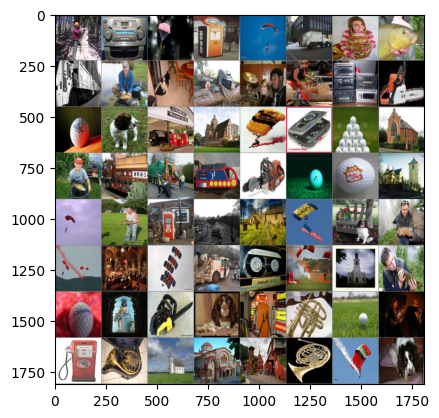

In [17]:
# Let's show some of the training images, for fun.
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
	img = img / 2 + 0.5  # unnormalize
	npimg = img.numpy()
	plt.imshow(np.transpose(npimg, (1, 2, 0)))
	plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

### Testing Base model

In [34]:
base_model_c = base_c()
base_model_c.apply(glorot_init)
base_model_c = base_model_c.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(base_model_c.parameters(), lr=0.05, weight_decay=0.001, momentum=0.9)

# Define learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [35]:
train_loss_mem = []
val_loss_mem = []
val_accuracy_mem = []

for epoch in range(200):
    base_model_c.train()  # Set model to training mode
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = base_model_c(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_loss_mem.append(train_loss)
    
    print(f'Epoch [{epoch + 1}] training loss: {train_loss:.3f}')
    
    # Validation phase
    base_model_c.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in test_loader:  # Assuming test_loader is used as a validation loader
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = base_model_c(inputs)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_running_loss / len(test_loader)
    val_accuracy = 100 * val_correct / val_total
    
    print(f'Epoch [{epoch + 1}] validation loss: {val_loss:.3f}, accuracy: {val_accuracy:.2f}%')
    val_loss_mem.append(val_loss)
    val_accuracy_mem.append(val_accuracy)
    # Update the LR scheduler with validation loss
    scheduler.step(val_loss)
    print(f'LR: {scheduler.get_last_lr()}')


Epoch [1] training loss: 2.283
Epoch [1] validation loss: 2.278, accuracy: 16.74%
LR: [0.05]
Epoch [2] training loss: 2.261
Epoch [2] validation loss: 2.235, accuracy: 17.04%
LR: [0.05]
Epoch [3] training loss: 2.255
Epoch [3] validation loss: 2.233, accuracy: 18.34%
LR: [0.05]
Epoch [4] training loss: 2.231
Epoch [4] validation loss: 2.174, accuracy: 18.52%
LR: [0.05]


KeyboardInterrupt: 

## Define All_CNN_C

In [38]:
class all_cnn_c(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.dropout1 = nn.Dropout2d(p=0.2)
        
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=96,
            kernel_size=(3,3),
            stride=1, padding=1, bias=False,
        )
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(
            in_channels=96, out_channels=96,
            kernel_size=(3,3),
            stride=1, padding=1, bias=False,
        )
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(
            in_channels=96, out_channels=96,
            kernel_size=(3,3),
            stride=2, padding=1,
        ) # Replace MP with this conv
        #self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout2d(p=0.5)
        
        self.conv4 = nn.Conv2d(
            in_channels=96, out_channels=192,
            kernel_size=(3,3),
            stride=1, padding=1, bias=False,
        )
        self.relu4 = nn.ReLU()
        
        self.conv5 = nn.Conv2d(
            in_channels=192, out_channels=192,
            kernel_size=(3,3),
            stride=1, padding=1, bias=False,
        )
        self.relu5 = nn.ReLU()
        
        self.conv6 = nn.Conv2d(
            in_channels=192, out_channels=192,
            kernel_size=(3,3),
            stride=2, padding=1,
        ) # Replace MP with this conv
        #self.relu6 = nn.ReLU()
        self.dropout3 = nn.Dropout2d(p=0.5)
        
        self.conv7 = nn.Conv2d(
            in_channels=192, out_channels=192,
            kernel_size=(3,3),
            stride=1, padding=0, bias=False,
        )
        self.relu7 = nn.ReLU()
        
        self.conv8 = nn.Conv2d(
            in_channels=192, out_channels=192,
            kernel_size=(1,1),
            stride=1, padding=0, bias=False,
        )
        self.relu8 = nn.ReLU()
        
        self.conv9 = nn.Conv2d(
            in_channels=192, out_channels=10,
            kernel_size=(1,1),
            stride=1, padding=0, bias=False,
        )
        self.relu9 = nn.ReLU()
        
        self.avg_pool = nn.AvgPool2d(
            #kernel_size=(6,6)
            kernel_size=(54,54)
        )
        
        
    def forward(self, x):
        x = self.dropout1(x)
        #print(f'Shape after dropout1: {x.shape}')
        x = self.conv1(x)
        x = self.relu1(x)
        #print(f'Shape after conv1: {x.shape}')
        x = self.conv2(x)
        x = self.relu2(x)
        #print(f'Shape after conv2: {x.shape}')
        x = self.conv3(x)
        #x = self.relu3(x)
        x = self.dropout2(x)
        #print(f'Shape after conv3: {x.shape}')
        x = self.conv4(x)
        x = self.relu4(x)
        #print(f'Shape after conv4: {x.shape}')
        x = self.conv5(x)
        x = self.relu5(x)
        #print(f'Shape after conv5: {x.shape}')
        x = self.conv6(x)
        #x = self.relu6(x)
        x = self.dropout3(x)
        #print(f'Shape after conv1: {x.shape}')
        x = self.conv7(x)
        x = self.relu7(x)
        #print(f'Shape after conv1: {x.shape}')
        x = self.conv8(x)
        x = self.relu8(x)
        #print(f'Shape after conv1: {x.shape}')
        x = self.conv9(x)
        x = self.relu9(x)
        #print(f'Shape after conv1: {x.shape}')
        x = self.avg_pool(x)
        #print(f'Shape after global pool layer: {x.shape}')
        x = torch.flatten(x, start_dim=1)
        #print(f'out shape: {x.shape}')
        return x

def glorotinit(net):
    if isinstance(net, nn.Conv2d):
        nn.init.xavier_normal_(net.weight)
        if net.bias is not None:
            nn.init.constant_(net.bias, 0)

all_cnn_c_model = all_cnn_c()
all_cnn_c_model.apply(glorot_init)
all_cnn_c_model = all_cnn_c_model.to(device)
summary(all_cnn_c_model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
all_cnn_c                                [1, 10]                   --
├─Dropout2d: 1-1                         [1, 3, 224, 224]          --
├─Conv2d: 1-2                            [1, 96, 224, 224]         2,592
├─ReLU: 1-3                              [1, 96, 224, 224]         --
├─Conv2d: 1-4                            [1, 96, 224, 224]         82,944
├─ReLU: 1-5                              [1, 96, 224, 224]         --
├─Conv2d: 1-6                            [1, 96, 112, 112]         83,040
├─Dropout2d: 1-7                         [1, 96, 112, 112]         --
├─Conv2d: 1-8                            [1, 192, 112, 112]        165,888
├─ReLU: 1-9                              [1, 192, 112, 112]        --
├─Conv2d: 1-10                           [1, 192, 112, 112]        331,776
├─ReLU: 1-11                             [1, 192, 112, 112]        --
├─Conv2d: 1-12                           [1, 192, 56, 56]       

In [ ]:
dummy_in = torch.randn(1, 3, 32, 32)
dummy_in = dummy_in.to(device)
out = all_cnn_c_model(dummy_in)

### Testing ALL_CNN_C

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(all_cnn_c_model.parameters(), lr=0.05, weight_decay=0.001, momentum=0.9)

# Define learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

train_loss_mem = []
val_loss_mem = []
val_accuracy_mem = []

for epoch in range(200):
    all_cnn_c_model.train()  # Set model to training mode
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = all_cnn_c_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_loss_mem.append(train_loss)
    
    print(f'Epoch [{epoch + 1}] training loss: {train_loss:.3f}')
    
    # Validation phase
    all_cnn_c_model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in test_loader:  # Assuming test_loader is used as a validation loader
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = all_cnn_c_model(inputs)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_running_loss / len(test_loader)
    val_accuracy = 100 * val_correct / val_total
    
    print(f'Epoch [{epoch + 1}] validation loss: {val_loss:.3f}, accuracy: {val_accuracy:.2f}%')
    val_loss_mem.append(val_loss)
    val_accuracy_mem.append(val_accuracy)
    # Update the LR scheduler with validation loss
    scheduler.step(val_loss)
    print(f'LR: {scheduler.get_last_lr()}')


Epoch [1] training loss: 2.299
Epoch [1] validation loss: 2.298, accuracy: 12.51%
LR: [0.05]
Epoch [2] training loss: 2.294
Epoch [2] validation loss: 2.302, accuracy: 10.34%
LR: [0.05]
Epoch [3] training loss: 2.288
Epoch [3] validation loss: 2.284, accuracy: 11.31%
LR: [0.05]
Epoch [4] training loss: 2.288
Epoch [4] validation loss: 2.299, accuracy: 9.20%
LR: [0.05]
Epoch [5] training loss: 2.284
Epoch [5] validation loss: 2.289, accuracy: 16.25%
LR: [0.05]
Epoch [6] training loss: 2.250
Epoch [6] validation loss: 2.204, accuracy: 18.75%
LR: [0.05]
Epoch [7] training loss: 2.231
Epoch [7] validation loss: 2.204, accuracy: 18.22%
LR: [0.05]
Epoch [8] training loss: 2.242
Epoch [8] validation loss: 2.234, accuracy: 19.87%
LR: [0.05]
Epoch [9] training loss: 2.231
Epoch [9] validation loss: 2.213, accuracy: 20.08%
LR: [0.05]
Epoch [10] training loss: 2.235
Epoch [10] validation loss: 2.236, accuracy: 17.66%
LR: [0.005000000000000001]
Epoch [11] training loss: 2.201
Epoch [11] validation